In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import cv2
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.colab.patches import cv2_imshow

In [4]:
main_path = '/content/drive/MyDrive/Colab Notebooks/Biometrics/facial-keypoints-detection/'

train_data = pd.read_csv(main_path+'training/training.csv', header=0, sep=',', quotechar='"')
test_data = pd.read_csv(main_path+'test/test.csv', header=0, sep=',', quotechar='"')
IdLookupTable = pd.read_csv(main_path+'IdLookupTable.csv', header=0, sep=',', quotechar='"')
SampleSubmission = pd.read_csv(main_path+'SampleSubmission.csv', header=0, sep=',', quotechar='"')

In [ ]:
train_data.head(5).T.tail()

,0,1,2,3,4
mouth_center_top_lip_x,43.3126,46.6846,47.2749,50.3032,44.9627
mouth_center_top_lip_y,72.9355,70.2666,70.1918,70.0917,73.7074
mouth_center_bottom_lip_x,43.1307,45.4679,47.2749,51.5612,44.2271
mouth_center_bottom_lip_y,84.4858,85.4802,78.6594,78.2684,86.8712
Image,238 236 237 238 240 240 239 241 241 243 240 23...,219 215 204 196 204 211 212 200 180 168 178 19...,144 142 159 180 188 188 184 180 167 132 84 59 ...,193 192 193 194 194 194 193 192 168 111 50 12 ...,147 148 160 196 215 214 216 217 219 220 206 18...


In [5]:
print("In the train set there are: {} images".format(len(train_data['Image'])))
dimImg = np.sqrt(len(train_data['Image'][0].split())).astype(int)
print("Each image has dimensions: {}x{}.".format(dimImg, dimImg))

In the train set there are: 7049 images
Each image has dimensions: 96x96.


In [ ]:
print("The images features are:\n\n{}".format(pd.Series(train_data.columns)))

The images features are:

0             left_eye_center_x
1             left_eye_center_y
2            right_eye_center_x
3            right_eye_center_y
4       left_eye_inner_corner_x
5       left_eye_inner_corner_y
6       left_eye_outer_corner_x
7       left_eye_outer_corner_y
8      right_eye_inner_corner_x
9      right_eye_inner_corner_y
10     right_eye_outer_corner_x
11     right_eye_outer_corner_y
12     left_eyebrow_inner_end_x
13     left_eyebrow_inner_end_y
14     left_eyebrow_outer_end_x
15     left_eyebrow_outer_end_y
16    right_eyebrow_inner_end_x
17    right_eyebrow_inner_end_y
18    right_eyebrow_outer_end_x
19    right_eyebrow_outer_end_y
20                   nose_tip_x
21                   nose_tip_y
22          mouth_left_corner_x
23          mouth_left_corner_y
24         mouth_right_corner_x
25         mouth_right_corner_y
26       mouth_center_top_lip_x
27       mouth_center_top_lip_y
28    mouth_center_bottom_lip_x
29    mouth_center_bottom_lip_y
30            

In [ ]:
# during test phase we are looking for 27124 missing points
print("The LookUpTable is:\n\n{}".format(IdLookupTable))

The LookUpTable is:

       RowId  ImageId                FeatureName  Location
0          1        1          left_eye_center_x       NaN
1          2        1          left_eye_center_y       NaN
2          3        1         right_eye_center_x       NaN
3          4        1         right_eye_center_y       NaN
4          5        1    left_eye_inner_corner_x       NaN
...      ...      ...                        ...       ...
27119  27120     1783         right_eye_center_y       NaN
27120  27121     1783                 nose_tip_x       NaN
27121  27122     1783                 nose_tip_y       NaN
27122  27123     1783  mouth_center_bottom_lip_x       NaN
27123  27124     1783  mouth_center_bottom_lip_y       NaN

[27124 rows x 4 columns]


## Look for missing data

In [ ]:
# train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

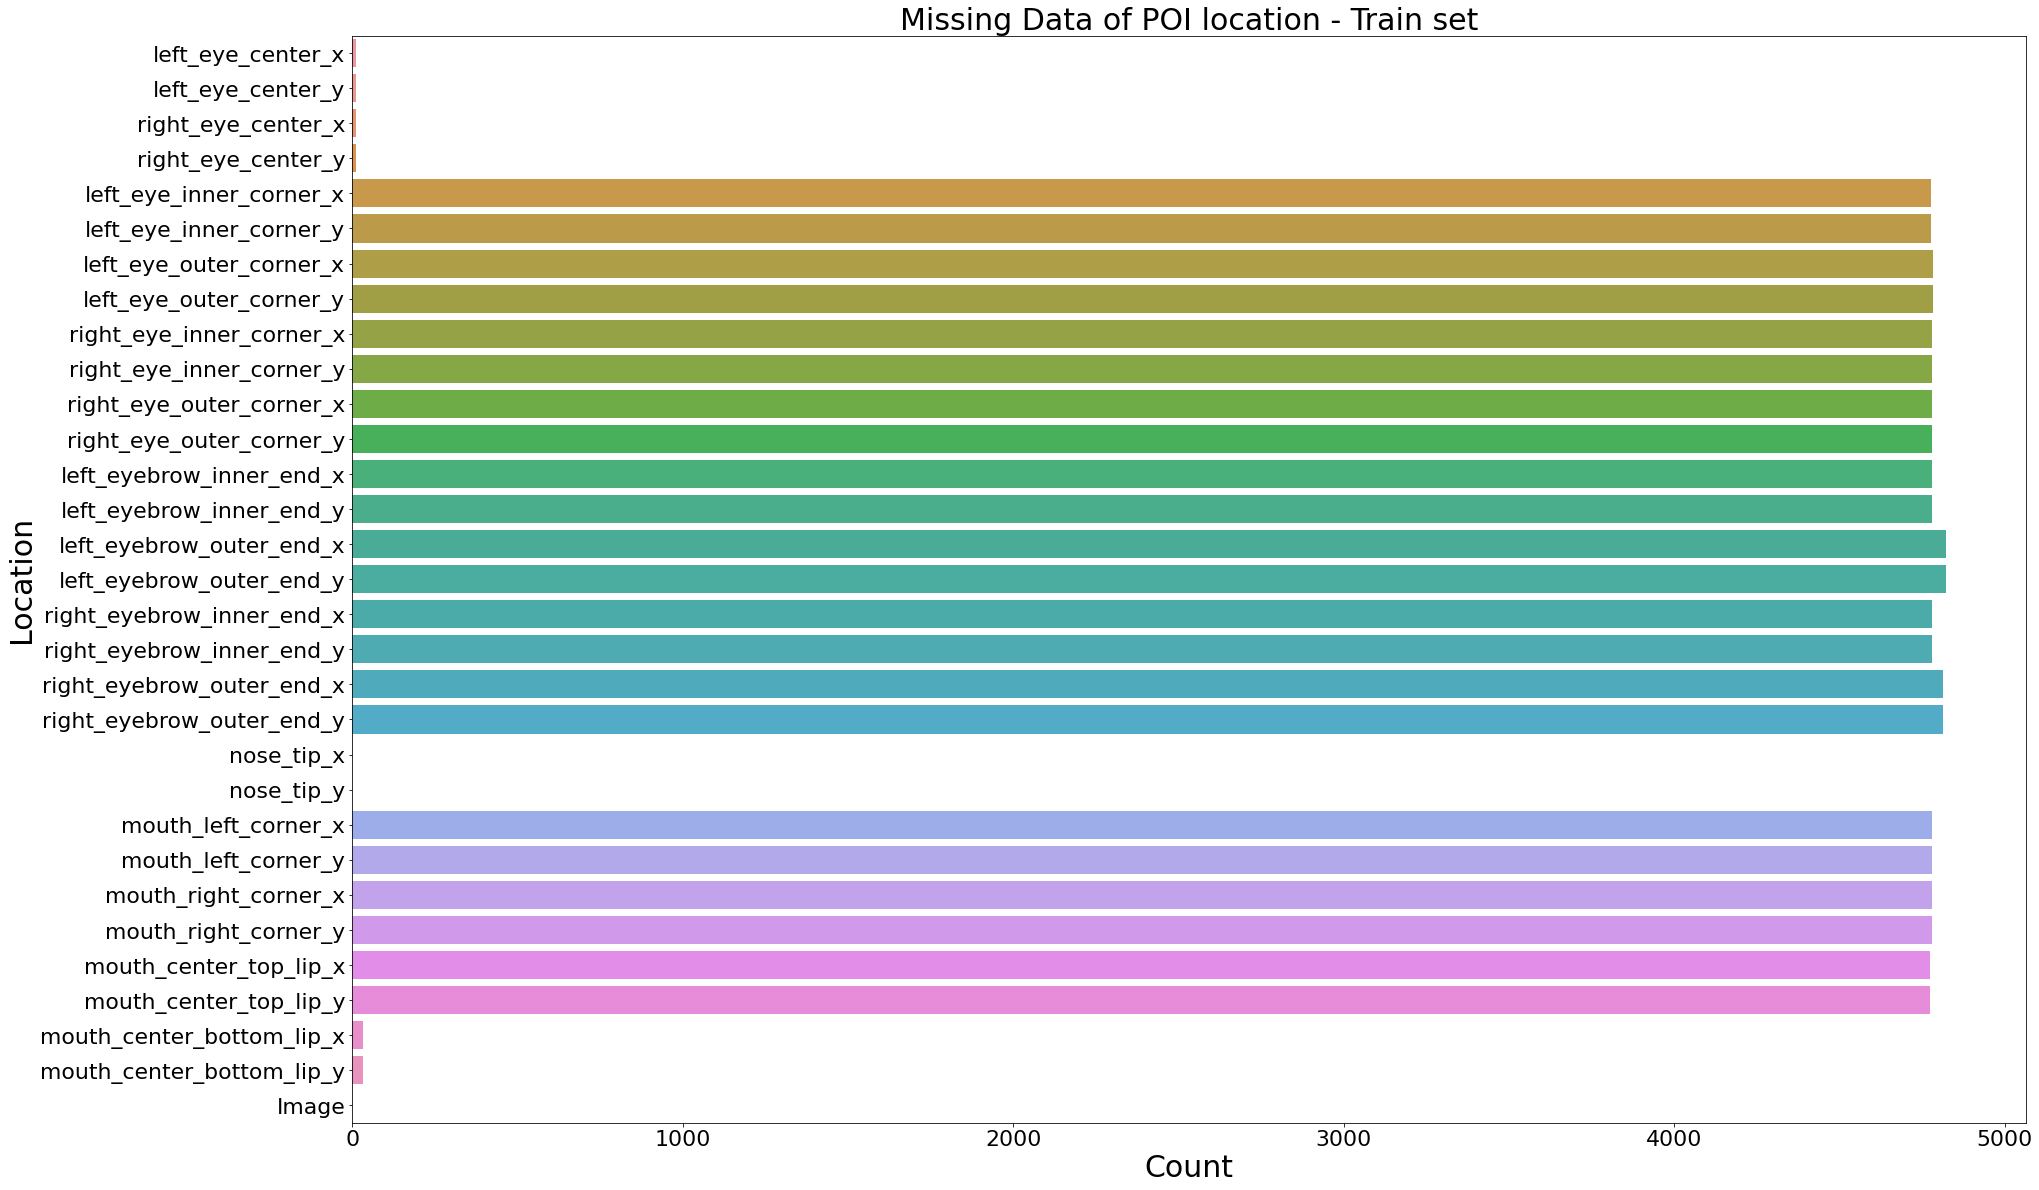

In [ ]:
plt.figure(figsize=(30,20))
fig = sns.barplot(x = train_data.isnull().sum().values, y = train_data.isnull().sum().index)
fig.tick_params(labelsize=22)
plt.xlabel("Count", fontsize=30)
plt.ylabel("Location", fontsize=30)
plt.title("Missing Data of POI location - Train set", fontsize=30)
plt.show()

### Imputing Missing Values on Train set

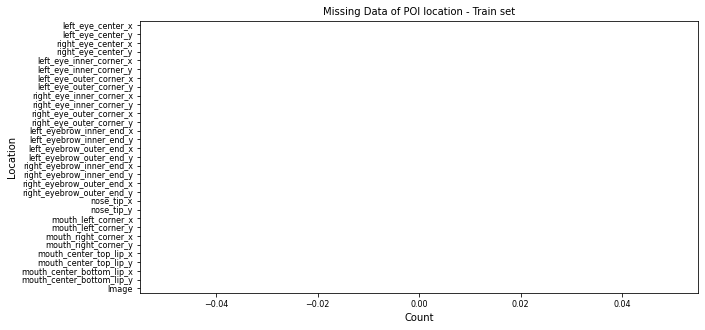

In [6]:
train_data.fillna(method = 'ffill',inplace = True) # quite a naive method, it can be improved 

plt.figure(figsize=(10,5))
fig = sns.barplot(x = train_data.isnull().sum().values, y = train_data.isnull().sum().index)
fig.tick_params(labelsize=8)
plt.xlabel("Count", fontsize=10)
plt.ylabel("Location", fontsize=10)
plt.title("Missing Data of POI location - Train set", fontsize=10)
plt.show()

In [7]:
img_dt = []

for i in range(len(train_data)):
  img_dt.append(train_data['Image'][i].split(' '))
  
X = np.array(img_dt, dtype='float')

In [ ]:
# test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


## Visualize Data

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

Plot a single image

In [9]:
def plot_image(images,ix=0,showGrid=True):
  plt.imshow(np.array(images[ix].split(), dtype=np.uint8).reshape(96,96), cmap='gray')
  plt.grid(b=True) #must be set every time the grid must be shown 
  plt.show()

def plot_collage(images, rows=5, cols=5):
  fig = plt.figure(figsize=(5., 5.)) #might be too small, adjust as needed

  nImgs = rows*cols
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )
  for ax, im in zip(grid, images[0:nImgs]):
      # Iterating over the grid returns the Axes.
      ax.imshow(np.array(im.split(), dtype=np.uint8).reshape(96,96), cmap='gray')
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)

  plt.show()

def plot_image_markers(images, markers, ix=0):
  plt.imshow(np.array(images[ix].split(), dtype=np.uint8).reshape(96,96), cmap='gray')
  plt.scatter(markers[ix][0::2], markers[ix][1::2], c='red', marker='*')
  plt.title("Image with Facial Keypoints")
  plt.show()


def plot_collage_markers(images, markers, rows=5, cols=5):
  nImgs = rows*cols
  fig = plt.figure(figsize=(10., 10.))

  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                  axes_pad=0.01,  # pad between axes in inch.
                  )

  ix = 0
  for ax, im in zip(grid, images[0:nImgs]):
      # Iterating over the grid returns the Axes.
      ax.imshow(np.array(im.split(), dtype=np.uint8).reshape(96,96), cmap='gray')
      ax.scatter(markers[ix][0::2], markers[ix][1::2], c='red', marker='*')
      ix += 1
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)

  plt.show()

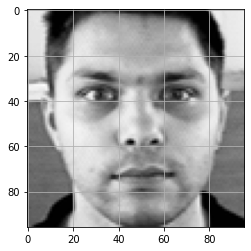

In [10]:
train_dataT = train_data.T # the features are now the indexes and the columns represent the features values for each image 
trainImages = train_dataT.loc["Image"] #array containing the images represented as Strings of int values

trainImages_res = [[]]*len(train_data)

for ix in range(len(train_data)):
    imgIX = np.array(train_dataT.loc["Image"][ix].split(),dtype=np.uint8).reshape((96,96))
    trainImages_res[ix] = imgIX


plot_image(trainImages, 3)

Plot Image Collage

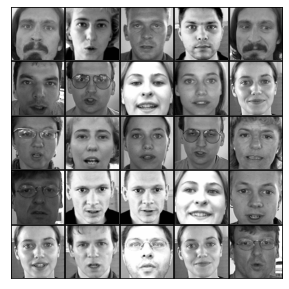

In [ ]:
plot_collage(trainImages)

### Plotting the Facial Keypoints

In [12]:
facial_pts_train = train_data.drop(columns=['Image'], axis=1)
facial_pts = []

for i in range(len(facial_pts_train)):
  facial_pts.append(facial_pts_train.iloc[i])

y = np.array(facial_pts, dtype='float')
t = facial_pts_train.iloc[0].values

Plot markers for a single image

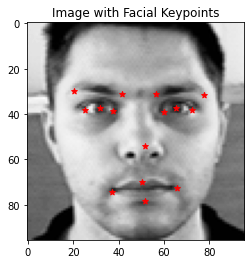

In [ ]:
plot_image_markers(trainImages, facial_pts, ix=3)

Plot markers for a collage of images

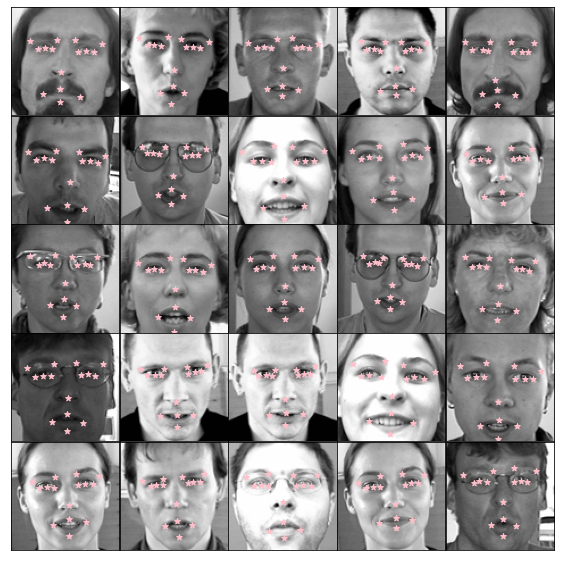

In [ ]:
plot_collage_markers(trainImages, facial_pts)

### Generate Heatmaps for the Keypoints

#### define Grid size and radius

In [13]:
from scipy import stats, integrate


In [14]:
def gaussian(xL, yL, H, W, sigma=5):
  channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
  channel = np.array(channel, dtype=np.float32)
  channel = np.reshape(channel, newshape=(H, W))
  
  return channel

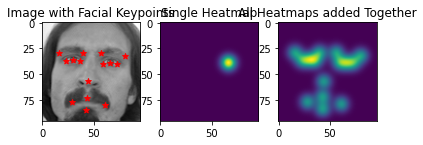

In [15]:
#Generate heatmaps for one sample image
heatmaps = []

for i in range(0, 30, 2): # ho 15 poi, salto ogni 2 per andare al prossimo poi
    x = int(y[0][i]) # x coord
    Y = int(y[0][i + 1]) # y coord
    heatmap = gaussian(x, Y, 96, 96)
    heatmaps.append(heatmap)
    
heatmaps = np.array(heatmaps)

plt.subplot(1,3,1)
plt.imshow(trainImages_res[0], cmap='gray')
plt.scatter(t[0::2], t[1::2], c='red', marker='*')
plt.title("Image with Facial Keypoints")

plt.subplot(1,3,2)
plt.imshow(heatmaps[0])
plt.title("Single Heatmap")

plt.subplot(1,3,3)
plt.imshow(heatmaps.sum(axis=0))
plt.title("All Heatmaps added Together")
plt.show()




# Part II - Building the Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

## Convolutional Neural Network (CNN)

In [18]:
# 4-layered CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # SEE THE FORWARD FUNCTION COMMENTS TO SEE WHERE THE DIMENSIONS OF THE IMAGE COME FROM
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5) # (b,1,96,96) to (b,4,92,92)
        self.conv1_bn = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3) # (b,4,46,46) to (b,64,44,44)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3) # (b,64,22,22) to (b,128,20,20)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3) # (b,128,10,10) to (b,256,8,8)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 30)
        self.dp1 = nn.Dropout(p=0.4)
    
        
    
    def forward(self, x, verbose=False):
        # 1 CONVOLUTIONAL LAYER
        # Input size: 96x96
        # (Hinput_size - Hkernel_size + 1 = Outputsize)
        # Output size = 96-5+1 = 92 
        # Max Pool from 1 Layer
        # Output after Max Pooling window (2,2): (92-2+2)/2 = 46
        x = self.conv1_bn(self.conv1(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dp1(x)
        
        # 2 CONVOLUTIONAL LAYER
        # Input size: 46x46
        # (Hinput_size - Hkernel_size + 1 = Outputsize)
        # Output size = 46-3+1 = 44 
        # Max Pool from 2 Layer
        # Output after Max Pooling window (2,2): (44-2+2)/2 = 22
        x = self.conv2_bn(self.conv2(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dp1(x)
        
        # 3 CONVOLUTIONAL LAYER
        # Input size: 22x22
        # (Hinput_size - Hkernel_size + 1 = Outputsize)
        # Output size = 22-3+1 = 20
        # Max Pool from 3 Layer
        # Output after Max Pooling window (2,2): (20-2+2)/2 = 10
        x = self.conv3_bn(self.conv3(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dp1(x)
        
        # 4 CONVOLUTIONAL LAYER
        # Input size: 10x10
        # (Hinput_size - Hkernel_size + 1 = Outputsize)
        # Output size = 10-3+1 = 8
        # Max Pool from 4 Layer
        # Output after Max Pooling window (2,2): (8-2+2)/2 = 4
        x = self.conv4_bn(self.conv4(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dp1(x)
        
        # END OF THE CONVOLTUTION STAGE
        # 256 outputs of size 4x4
        x = x.view(-1, 256*4*4)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dp1(x)
        x = self.fc3(x)
        return x


In [19]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def testing(model, device, valid_loader):
  # specify the eval phase
  model.eval()
  test_loss = 0
  for data, target in valid_loader:
    data, target = data.to(device), target.to(device)
    
    # Arrange data dimensions to feed the model
    data = data.view(-1, 96*96)
    data = data.view(-1, 1, 96, 96)

    # Predict coords. of test data
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
  
  test_loss /= len(valid_loader.dataset)
  return test_loss

def training(epochs, model, criterion, device, train_loader, valid_loader, optimizer):
  train_error_list = []
  val_error_list = []
  for epoch in range(epochs):
    # specify training mode
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      data = data.view(-1, 96*96)
      data = data.view(-1, 1, 96, 96)

      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      train_loss += loss.item()
      loss.backward()
      optimizer.step()
    
    train_loss /= len(train_loader.dataset)
    # send validation data to testing data and evaluate the model performance
    eval_loss = testing(model, device, valid_loader)
    
    train_error_list.append(train_loss)
    val_error_list.append(eval_loss)

    if (epoch+1) % 10 == 0:
      print("End of epoch {}: \nTraining error = [{}]\tValidation error = [{}]".format(epoch+1, train_loss, eval_loss))
  return train_error_list, val_error_list, epoch, optimizer, train_loss

In [21]:
def my_train_test_split(X, validation_split):
  dataset_size = len(X)
  indices = list(range(dataset_size))
  val_num  = int(np.floor(validation_split*dataset_size))
  np.random.shuffle(indices)

  # split the indexes
  train_indices, val_indices = indices[val_num:], indices[:val_num]
  
  train_sampler = data_utils.SubsetRandomSampler(train_indices)
  valid_sampler = data_utils.SubsetRandomSampler(val_indices)

  loader_object = data_utils.TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
  train_loader = data_utils.DataLoader(loader_object, batch_size=32, sampler=train_sampler)
  valid_loader = data_utils.DataLoader(loader_object, batch_size=32, sampler=valid_sampler)

  return train_loader, valid_loader

In [22]:
def get_n_params(model):
  np=0
  for p in list(model.parameters()):
    np += p.nelement()
  return np

In [23]:
n_hidden = 128 #hidden units
output_size = 30 # we have to predict 30 coords

# split the original dataset
train_loader, valid_loader = my_train_test_split(X, 0.2)

# instantiate the model
model = CNN()
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters())

print('Number of parameters: {}'.format(get_n_params(model)))

train_error_list, valid_error_list, epoch, optimizer, loss = training(3, model, criterion, device, train_loader, valid_loader, optimizer)

Number of parameters: 4837838


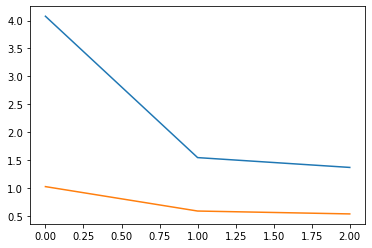

In [ ]:
plt.plot(train_error_list)
plt.plot(valid_error_list)

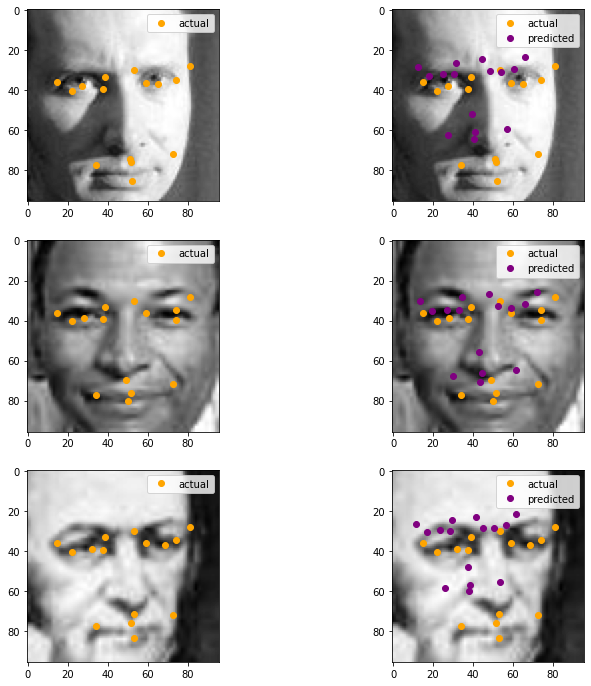

In [ ]:
def plot_samples(X, y, model, num_samples):
  fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(12,12))
  
  for row in range(num_samples):
    # get random indexes to dispaly the results on the images
    sample_idx = np.random.choice(len(X))
    x = X[sample_idx]
    x = torch.from_numpy(x).float().view(1,1,96,96).to(device)
    actual_y = y[sample_idx]
    pred_y = model(x)
    img = X[sample_idx].reshape(96,96)
    
    # Set the coordinates data so we can plot them along the original image
    actual_y = np.vstack(np.split(actual_y, 15)).T
    pred_y = pred_y.cpu().data.numpy()[0]
    pred_y = np.vstack(np.split(pred_y, 15)).T
    
    # Representation
    axes[row, 0].imshow(img, cmap='gray')
    axes[row, 0].plot(actual_y[0], actual_y[1], 'o', color='orange', label='actual')
    axes[row, 0].legend()
    axes[row, 1].imshow(img, cmap='gray')
    axes[row, 1].plot(actual_y[0], actual_y[1], 'o', color='orange', label='actual')
    axes[row, 1].plot(pred_y[0], pred_y[1], 'o', color='purple', label='predicted')
    axes[row, 1].legend()

 # change three for another number to see display the results in more than three pictures 
plot_samples(X, y, model, 3)

### Save dict model

In [ ]:
MODEL_NAME = 'base_model.tar'
DEST_PATH = '/content/drive/MyDrive/Colab Notebooks/Biometrics/'

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
},DEST_PATH+MODEL_NAME)

# Augmenting the Images

In [ ]:
from sklearn.model_selection import train_test_split
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

Let's split training data in 2 part, so that we have some data with Groundtruth that we will use during testing phase

In [ ]:
train_x, test_x, train_x, test_y = train_test_split(X, y, test_size=0.2)